In [ ]:
pip install opendatasets

In [4]:
project_name = 'hand-bag-new'
!pip install opendatasets --upgrade 
import opendatasets as od
od.download('https://www.kaggle.com/bashturtle/shirtshandbags')
import os
data_dir='./shirtshandbags'
print(os.listdir(data_dir))
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sadamneha19bce7755
Your Kaggle Key: ··········


100%|██████████| 39.0M/39.0M [00:00<00:00, 152MB/s]



['handbags', 'original_shirts']


In [5]:
im_sz = 64
batch_sz = 128
new_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train1 = ImageFolder(data_dir, transform=T.Compose([
T.Resize(im_sz), T.CenterCrop(im_sz), T.ToTensor(), T.Normalize(*new_stats)]))

In [6]:
train2 = DataLoader(train1, batch_sz, shuffle=True, num_workers=3, pin_memory=True)
def denormalize(im_tensors):
  return im_tensors * new_stats[1][0] + new_stats[0][0] 
def show_img(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


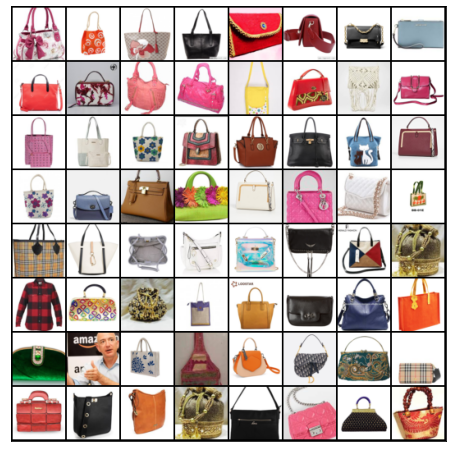

In [7]:
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_img(images, nmax)
    break 
show_batch(train2)
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data] 
  return data.to(device, non_blocking=True)
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl 
    self.device = device
  def __iter__(self): 
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self): 
    return len(self.dl)
device=get_device()
train2 = DeviceDataLoader(train2, device)

In [8]:
import torch.nn as nn
discriminator = nn.Sequential(
nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # in: 3 x 64 x 64 nn.BatchNorm2d(64),
nn.LeakyReLU(0.2, inplace=True),
nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # out: 64 x 32 x 32 nn.BatchNorm2d(128),
nn.LeakyReLU(0.2, inplace=True),
nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256),# out: 128 x 16 x 16
nn.LeakyReLU(0.2, inplace=True),
nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512),# out: 256 x 8 x 8
nn.LeakyReLU(0.2, inplace=True),
nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # out: 512 x 4 x 4
nn.Flatten(), # out: 1 x 1 x 1
nn.Sigmoid())
discriminator = to_device(discriminator, device)

torch.Size([128, 3, 64, 64])


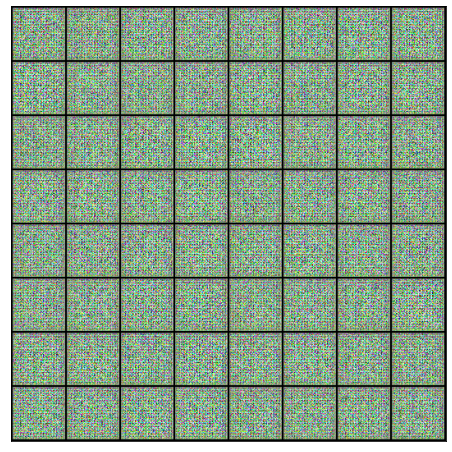

In [10]:
latent_size=128
#generator network
generator = nn.Sequential(
# in: latent_size x 1 x 1
nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False), # out: 512 x 4 x 4
nn.BatchNorm2d(512), nn.ReLU(True),
nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),#out: 256x8x8
nn.BatchNorm2d(256), nn.ReLU(True),
nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),#out:128x 16 x 16
nn.BatchNorm2d(128), nn.ReLU(True),
nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),#out:64 32 x 32
nn.BatchNorm2d(64), nn.ReLU(True),
nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),#out:3 x 64 x 64
nn.Tanh()
)
xb = torch.randn(batch_sz, latent_size, 1, 1) # random latent tensors 
fake_images = generator(xb)
print(fake_images.shape)
show_img(fake_images)
generator = to_device(generator, device)

In [11]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets) 
  real_score = torch.mean(real_preds).item()
  latent = torch.randn(batch_sz, latent_size, 1, 1, device=device) 
  fake_images = generator(latent)
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device) 
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets) 
  fake_score = torch.mean(fake_preds).item()
  loss = real_loss + fake_loss 
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [12]:
import torch.nn.functional as F
def train_generator(opt_g):
  opt_g.zero_grad()
  latent = torch.randn(batch_sz, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
  preds = discriminator(fake_images)
  targets = torch.ones(batch_sz, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)
  loss.backward()
  opt_g.step()
  return loss.item()

Saving generated-images-0000.png


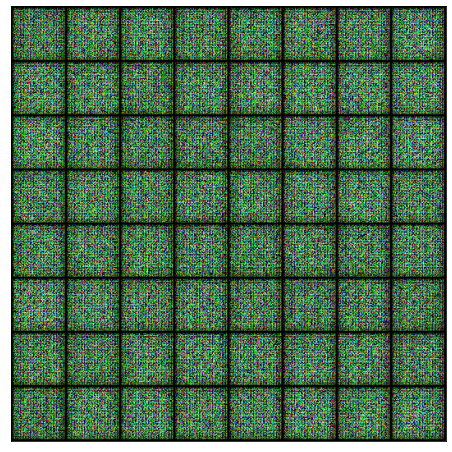

In [14]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index) 
  save_image(denormalize(fake_images), os.path.join(sample_dir, fake_fname), nrow=8) 
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([]) 
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device) 
save_samples(0, fixed_latent)

In [15]:
from tqdm.notebook import tqdm
def fit(epochs, lr, start_idx=1): 
  torch.cuda.empty_cache()
  losses_g = [] 
  losses_d = [] 
  real_scores = [] 
  fake_scores = []
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)) 
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
  for epoch in range(epochs):
    for real_images, _ in tqdm(train2):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d) # Train generator
      loss_g = train_generator(opt_g) 
    losses_g.append(loss_g) 
    losses_d.append(loss_d) 
    real_scores.append(real_score) 
    fake_scores.append(fake_score)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    save_samples(epoch+start_idx, fixed_latent, show=False)
  return losses_g, losses_d, real_scores, fake_scores  

  

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 6.6107, loss_d: 0.6522, real_score: 0.6672, fake_score: 0.0007
Saving generated-images-0001.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 4.8819, loss_d: 0.8084, real_score: 0.9666, fake_score: 0.5084
Saving generated-images-0002.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 2.9176, loss_d: 0.8268, real_score: 0.6083, fake_score: 0.1084
Saving generated-images-0003.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 1.4192, loss_d: 0.8639, real_score: 0.6165, fake_score: 0.2288
Saving generated-images-0004.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 2.7460, loss_d: 0.7634, real_score: 0.7603, fake_score: 0.3604
Saving generated-images-0005.png


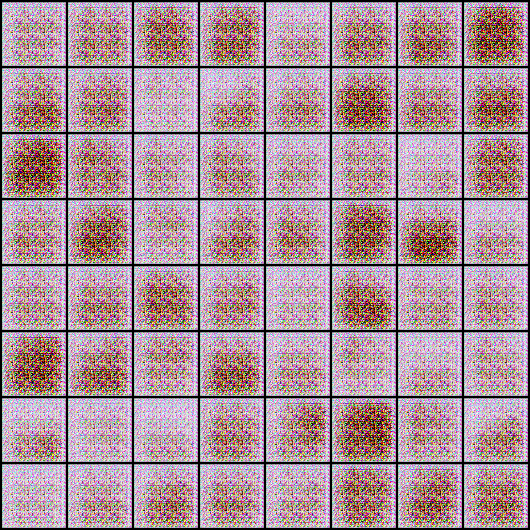

In [17]:
lr = 0.0003
epochs =5
history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history 
torch.save(generator.state_dict(), 'G.pth') 
torch.save(discriminator.state_dict(), 'D.pth')
from IPython.display import Image 
Image('./generated/generated-images-0001.png')

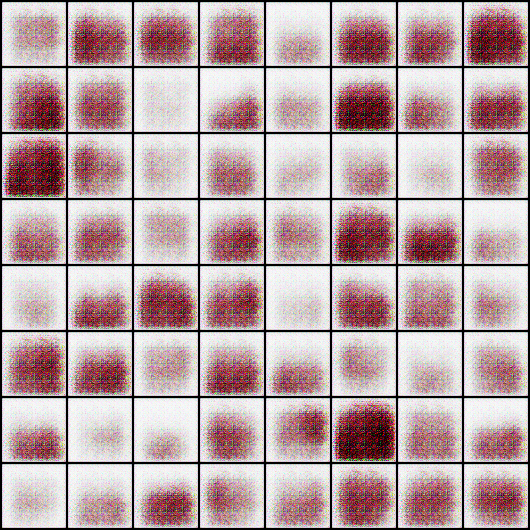

In [18]:
Image('./generated/generated-images-0004.png')